Парсер ODF файлов (PDS3 формат) для данных MGS (Mars Global Surveyor).

Назначение: извлечение доплеровских измерений для решения задачи уточнения орбиты.


ПАРСИНГ ДОПЛЕРОВСКИХ ДАННЫХ MGS (Mars Global Surveyor)
Формат: PDS3 (ODF + LBL файлы)

Найдено LBL файлов: 8

Обработка: 7261262a.lbl
  Прочитано LBL: 7261262a.lbl, найдено таблиц: 18
  Найдена таблица: ODF3C_TABLE
  Парсинг файла: 7261262A.ODF
    Начало парсинга: 7261262A.ODF, смещение: 180 байт
    Обработано: 1339 записей
    Валидных: 765, пропущено: 574
  ✓ Добавлено 765 записей

Обработка: 7262262a.lbl
  Прочитано LBL: 7262262a.lbl, найдено таблиц: 16
  Найдена таблица: ODF3C_TABLE
  Парсинг файла: 7262262A.ODF
    Начало парсинга: 7262262A.ODF, смещение: 180 байт
    Обработано: 667 записей
    Валидных: 402, пропущено: 265
  ✓ Добавлено 402 записей

Обработка: 7262262b.lbl
  Прочитано LBL: 7262262b.lbl, найдено таблиц: 16
  Найдена таблица: ODF3C_TABLE
  Парсинг файла: 7262262B.ODF
    Начало парсинга: 7262262B.ODF, смещение: 180 байт
    Обработано: 443 записей
    Валидных: 120, пропущено: 323
  ✓ Добавлено 120 записей

Обработка: 7262262c.lbl
  Прочитано LBL: 7262262c.lbl,

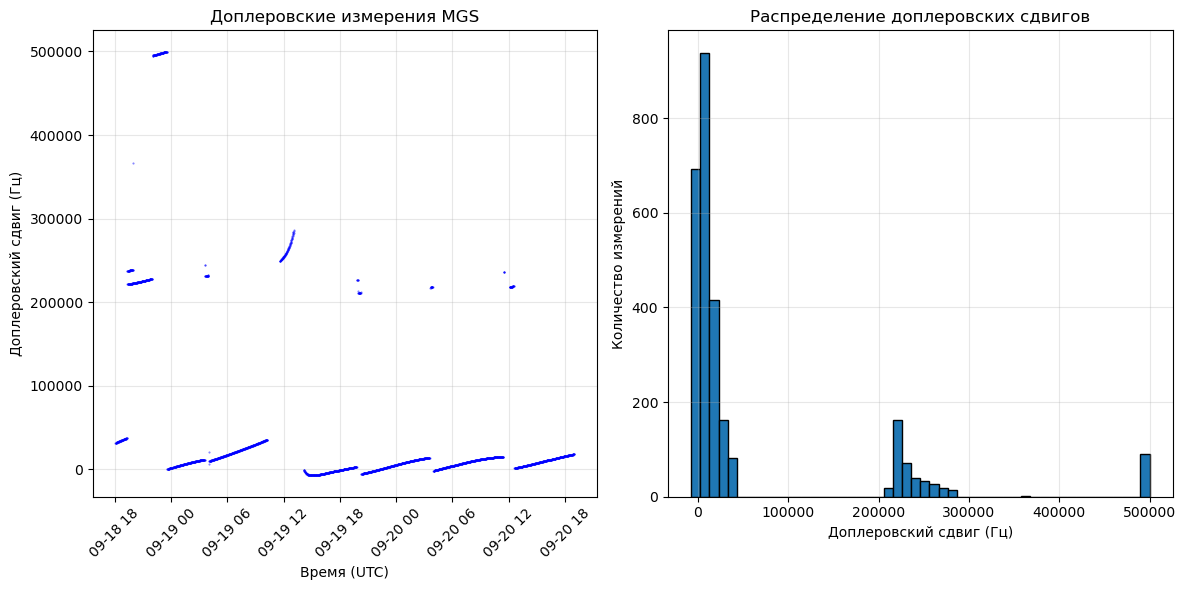

In [37]:
import os
import re
import pandas as pd
import numpy as np
import struct
from datetime import datetime, timedelta
from pathlib import Path

class MGSDopplerParserPDS3:
    """Класс для парсинга доплеровских данных MGS из файлов формата PDS3 (ODF+LBL)."""
    
    def __init__(self, verbose=True):
        """
        Инициализация парсера.
        
        Args:
            verbose (bool): Вывод подробной информации о процессе.
        """
        self.epoch_1950 = datetime(1950, 1, 1, 0, 0, 0)
        self.verbose = verbose
        

    # 1. ФУНКЦИИ ЧТЕНИЯ ФАЙЛОВ И СТРУКТУРЫ    
    def parse_lbl_file(self, lbl_path):
        """Читает LBL файл и возвращает информацию о таблицах."""
        tables = {}
        try:
            with open(lbl_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            
            # Шаблон для поиска таблиц: ^TABLE_NAME = ("FILE.ODF", START_RECORD)
            table_pattern = r'^\^(\w+)\s*=\s*\(\s*"([^"]+)",\s*(\d+)\s*\)'
            matches = re.findall(table_pattern, content, re.MULTILINE)
            
            for table_name, odf_file, start_record in matches:
                # Ищем размер записи для этой таблицы
                rb_pattern = rf'{re.escape(table_name)}\.RECORD_BYTES\s*=\s*(\d+)'
                rb_match = re.search(rb_pattern, content)
                record_bytes = int(rb_match.group(1)) if rb_match else 36  # По умолчанию 36
                
                tables[table_name] = {
                    'odf_file': odf_file,
                    'start_record': int(start_record),
                    'record_bytes': record_bytes,
                    'lbl_file': lbl_path.name
                }
                
            if self.verbose:
                print(f"  Прочитано LBL: {lbl_path.name}, найдено таблиц: {len(tables)}")
                
        except Exception as e:
            print(f"  Ошибка чтения LBL файла {lbl_path.name}: {e}")
            
        return tables
    
    def find_odf_file(self, folder_path, odf_filename):
        """Находит ODF файл в указанной папке с учетом регистра."""
        folder = Path(folder_path)
        
        # 1. Точное совпадение
        exact_path = folder / odf_filename
        if exact_path.exists():
            return exact_path
        
        # 2. Поиск без учета регистра
        for file in folder.iterdir():
            if file.name.upper() == odf_filename.upper():
                return file
        
        # 3. Пробуем варианты расширений
        for ext in ['.ODF', '.odf', '.DAT', '.dat']:
            test_name = odf_filename
            if not test_name.endswith(ext):
                test_name = f"{odf_filename}{ext}"
            test_path = folder / test_name
            if test_path.exists():
                return test_path
                
        return None
    

    # 2. ФУНКЦИИ ПАРСИНГА И ФИЛЬТРАЦИИ ДАННЫХ    
    def extract_bits_from_bytes(self, byte_data, start_bit, num_bits):
        """Извлекает биты из массива байт (MSB first, биты нумеруются с 1)."""
        if not byte_data or len(byte_data) == 0:
            return 0
            
        try:
            value = int.from_bytes(byte_data, byteorder='big', signed=False)
            total_bits = len(byte_data) * 8
            shift = total_bits - start_bit - num_bits + 1
            
            if shift < 0:
                return 0
                
            mask = (1 << num_bits) - 1
            return (value >> shift) & mask
        except:
            return 0
    
    def extract_data_type_info(self, items_6_14_bytes):
        """Извлекает информацию из полей Items 6-14 (4 байта)."""
        # Альтернативный метод: распаковка через битовые операции
        if len(items_6_14_bytes) >= 4:
            bits_value = struct.unpack('>I', items_6_14_bytes)[0]
            
            # Распаковка полей согласно стандартному формату ODF
            format_id = (bits_value >> 29) & 0x07          # биты 1-3
            receiving_station = (bits_value >> 22) & 0x7F   # биты 4-10
            transmitting_station = (bits_value >> 15) & 0x7F # биты 11-17
            network_id = (bits_value >> 13) & 0x03         # биты 18-19
            data_type_id = (bits_value >> 7) & 0x3F        # биты 20-25 (6 бит)
            downlink_band = (bits_value >> 5) & 0x03       # биты 26-27
            uplink_band = (bits_value >> 3) & 0x03         # биты 28-29
            ref_freq_band = (bits_value >> 1) & 0x03       # биты 30-31
            data_validity = bits_value & 0x01              # бит 32
            
            return {
                'format_id': format_id,
                'receiving_station_id': receiving_station,
                'transmitting_station_id': transmitting_station,
                'network_id': network_id,
                'data_type_id': data_type_id,
                'downlink_band_id': downlink_band,
                'uplink_band_id': uplink_band,
                'ref_freq_band_id': ref_freq_band,
                'data_validity': data_validity
            }
        else:
            # Возвращаем значения по умолчанию
            return {k: 0 for k in ['format_id', 'receiving_station_id', 'transmitting_station_id',
                                  'network_id', 'data_type_id', 'downlink_band_id',
                                  'uplink_band_id', 'ref_freq_band_id', 'data_validity']}
    
    def parse_odf3c_record(self, chunk, skip_headers=True):
        """Парсит одну запись ODF3C из бинарных данных."""
        if len(chunk) < 36:
            return None
        
        try:
            # 1. Распаковка базовых полей
            time_int = struct.unpack('>I', chunk[0:4])[0]      # Record Time Tag, integer part
            time_frac = struct.unpack('>I', chunk[4:8])[0]     # Record Time Tag, fractional part
            obs_int = struct.unpack('>i', chunk[8:12])[0]      # Observable, integer part (SIGNED!)
            obs_frac = struct.unpack('>I', chunk[12:16])[0]    # Observable, fractional part
            
            # Пропускаем заголовочные записи
            if skip_headers and time_int < 1000000:
                return None
            
            # 2. Извлечение информации из полей Items 6-14
            items_6_14_bytes = chunk[16:20]
            type_info = self.extract_data_type_info(items_6_14_bytes)
            data_type_id = type_info['data_type_id']
            
            #  Фильтр по data_type_id
            # 11 2‑way Doppler (частота передатчика на станции фиксированная)
            # 12 Ramped Doppler (частота станции не постоянна, а рампится)
            valid_data_types = [11, 12]  
            if data_type_id not in valid_data_types:
                return None
            
            # 3. Вычисление доплеровского сдвига
            # doppler_hz = obs_int + obs_frac * 1e-9  # Формула 1 (наносекунды)
            doppler_hz = obs_int + obs_frac / 2**32  # Формула 2 (fix-point)
            
            # Фильтр по физической реалистичности
            # Доплер для межпланетной связи обычно в пределах ±100 кГц
            if abs(doppler_hz) > 500000:  # Порог в 500 кГц увеличен из-за многих пропущенных значений # TODO: поменять на 100 при необходимости
                return None
            
            # 4. Извлечение reference frequency (Items 15-19)
            # Частота, которую станция ожидает получить от аппарата, если бы не было доплеровского эффекта
            ref_freq_mhz = 0
            if len(chunk) >= 28:
                items_15_19_bytes = chunk[20:28]
                # Reference frequency: (item_18 * 2^24 + item_19) / 1000
                # Для простоты извлечем первые 4 байта как целое
                if len(items_15_19_bytes) >= 4:
                    ref_part = struct.unpack('>I', items_15_19_bytes[0:4])[0]
                    ref_freq_mhz = ref_part / 1000.0
            
            # 5. Вычисление временной метки
            total_seconds = time_int + time_frac / 2**32
            utc_time = self.epoch_1950 + timedelta(seconds=total_seconds)
            
            # Дополнительная проверка: дата должна быть в периоде работы MGS (1996-2006)
            if not (1996 <= utc_time.year <= 2006):
                # Но не пропускаем, если это тестовые данные
                if utc_time.year < 1950 or utc_time.year > 2100:
                    return None
            
            # 6. Формирование результата
            record = {
                'datetime_utc': utc_time,
                'time_tag_seconds': total_seconds,
                'time_int': time_int,
                'time_frac': time_frac,
                'doppler_hz': doppler_hz,
                'observable_int': obs_int,
                'observable_frac': obs_frac,
                'data_type_id': data_type_id,
                'receiving_station_id': type_info['receiving_station_id'],
                'transmitting_station_id': type_info['transmitting_station_id'],
                'network_id': type_info['network_id'],
                'format_id': type_info['format_id'],
                'data_validity': type_info['data_validity'],
                'downlink_band_id': type_info['downlink_band_id'],
                'uplink_band_id': type_info['uplink_band_id'],
                'ref_freq_band_id': type_info['ref_freq_band_id'],
                'ref_freq_mhz': ref_freq_mhz,
            }
            
            return record
            
        except Exception as e:
            if self.verbose and 'debug' in locals() and debug:
                print(f"    Ошибка парсинга записи: {e}")
            return None
    
    def parse_odf3c_table(self, odf_path, start_record, record_size=36, max_records=None):
        """Парсит таблицу ODF3C из файла."""
        records = []
        
        try:
            with open(odf_path, 'rb') as f:
                # Определяем размер файла
                file_size = os.path.getsize(odf_path)
                
                # Переходим к началу таблицы
                f.seek((start_record - 1) * record_size)
                
                if self.verbose:
                    print(f"    Начало парсинга: {odf_path.name}, смещение: {f.tell()} байт")
                
                # Читаем записи
                records_read = 0
                skipped_headers = 0
                skipped_invalid = 0
                
                while True:
                    if max_records and len(records) >= max_records:
                        break
                    
                    chunk = f.read(record_size)
                    if not chunk or len(chunk) < record_size:
                        break
                    
                    # Пропускаем явные текстовые заголовки (первые байты - ASCII)
                    if records_read == 0 and chunk[:4].isascii() and any(32 <= b <= 126 for b in chunk[:20]):
                        if self.verbose:
                            print(f"    Пропущен ASCII заголовок: {chunk[:30]}")
                        skipped_headers += 1
                        records_read += 1
                        continue
                    
                    record = self.parse_odf3c_record(chunk, skip_headers=True)
                    if record:
                        record['source_file'] = odf_path.name
                        record['record_number'] = records_read
                        records.append(record)
                    else:
                        skipped_invalid += 1
                    
                    records_read += 1
                
                if self.verbose:
                    print(f"    Обработано: {records_read} записей")
                    print(f"    Валидных: {len(records)}, пропущено: {skipped_invalid}")
                    
        except Exception as e:
            print(f"    Ошибка при чтении файла {odf_path.name}: {e}")
        
        return pd.DataFrame(records)
    

    # 3. ОСНОВНАЯ ФУНКЦИЯ ПАРСИНГА
    def parse_input_folder(self, input_folder, output_file="mgs_doppler_data.csv"):
        """
        Основная функция: парсит все файлы в указанной папке.
        
        Args:
            input_folder (str): Путь к папке с LBL/ODF файлами.
            output_file (str): Имя выходного CSV файла.
        
        Returns:
            pd.DataFrame: DataFrame с доплеровскими данными.
        """
        input_path = Path(input_folder)
        
        if not input_path.exists():
            print(f"Ошибка: папка {input_folder} не существует!")
            return pd.DataFrame()
        
        # Находим все LBL файлы
        lbl_files = list(input_path.glob("*.lbl"))
        if not lbl_files:
            print("LBL файлы не найдены! Ищем ODF файлы напрямую...")
            # Пробуем найти ODF файлы напрямую
            odf_files = list(input_path.glob("*.odf")) + list(input_path.glob("*.ODF"))
            if not odf_files:
                print("Файлы данных не найдены!")
                return pd.DataFrame()
            # Создаем виртуальную таблицу для прямого парсинга ODF
            all_data = []
            for odf_file in odf_files:
                if self.verbose:
                    print(f"Прямой парсинг: {odf_file.name}")
                # Предполагаем стандартные параметры
                df = self.parse_odf3c_table(odf_file, start_record=6, record_size=36)
                if not df.empty:
                    all_data.append(df)
        else:
            if self.verbose:
                print(f"Найдено LBL файлов: {len(lbl_files)}")
            
            all_data = []
            
            for lbl_file in lbl_files:
                if self.verbose:
                    print(f"\n{'='*60}")
                    print(f"Обработка: {lbl_file.name}")
                
                # Читаем структуру из LBL
                tables = self.parse_lbl_file(lbl_file)
                
                for table_name, table_info in tables.items():
                    # Ищем только таблицы ODF3C (доплеровские данные)
                    if 'ODF3C' not in table_name.upper():
                        continue
                    
                    if self.verbose:
                        print(f"  Найдена таблица: {table_name}")
                    
                    # Находим соответствующий ODF файл
                    odf_path = self.find_odf_file(input_folder, table_info['odf_file'])
                    if not odf_path:
                        print(f"  ODF файл не найден: {table_info['odf_file']}")
                        continue
                    
                    if self.verbose:
                        print(f"  Парсинг файла: {odf_path.name}")
                    
                    # Парсим таблицу
                    df = self.parse_odf3c_table(
                        odf_path,
                        table_info['start_record'],
                        table_info.get('record_bytes', 36)
                    )
                    
                    if not df.empty:
                        df['lbl_file'] = lbl_file.name
                        all_data.append(df)
                        if self.verbose:
                            print(f"  ✓ Добавлено {len(df)} записей")
                    elif self.verbose:
                        print(f"  ✗ Нет валидных данных")
        
        # Объединяем все данные
        if all_data:
            final_df = pd.concat(all_data, ignore_index=True)
            
            # Сортируем по времени
            if 'datetime_utc' in final_df.columns:
                final_df = final_df.sort_values('datetime_utc').reset_index(drop=True)
            elif 'time_tag_seconds' in final_df.columns:
                final_df = final_df.sort_values('time_tag_seconds').reset_index(drop=True)
            
            # Выводим статистику
            self.print_statistics(final_df)
            
            # Сохраняем в CSV
            if output_file:
                final_df.to_csv(output_file, index=False)
                print(f"\nДанные сохранены в файл: {output_file}")
                print(f"Всего записей: {len(final_df)}")
            
            return final_df
        else:
            print("\nНе найдено валидных данных!")
            return pd.DataFrame()
    
    def print_statistics(self, df, num_to_print=5):
        """Выводит статистику распарсенных данных."""
        if df.empty:
            print("Нет данных для статистики")
            return
        
        print(f"\n{'='*60}")
        print("СТАТИСТИКА ДОПЛЕРОВСКИХ ДАННЫХ MGS")
        print(f"{'='*60}")
        
        print(f"Всего записей: {len(df)}")
        
        if 'datetime_utc' in df.columns:
            print(f"Временной диапазон: {df['datetime_utc'].min()} - {df['datetime_utc'].max()}")
        
        if 'doppler_hz' in df.columns:
            print(f"Диапазон доплера: {df['doppler_hz'].min():.3f} - {df['doppler_hz'].max():.3f} Гц")
            print(f"Средний доплер: {df['doppler_hz'].mean():.3f} Гц")
            print(f"Стандартное отклонение: {df['doppler_hz'].std():.3f} Гц")
        
        if 'data_type_id' in df.columns:
            print(f"\nРаспределение по data_type_id:")
            type_counts = df['data_type_id'].value_counts().sort_index()
            for dtype, count in type_counts.items():
                print(f"  {dtype}: {count} записей")
        
        if 'receiving_station_id' in df.columns:
            print(f"\nРаспределение по станциям (receiving_station_id):")
            station_counts = df['receiving_station_id'].value_counts().sort_index()
            for station, count in station_counts.items():
                print(f"  Станция {station}: {count} записей")
        
        # Первые несколько записей для проверки
        if len(df) > 0:
            print(f"\nПервые {num_to_print} записей:")
            cols_to_show = ['datetime_utc', 'doppler_hz', 'data_type_id', 
                           'receiving_station_id', 'source_file']
            available_cols = [c for c in cols_to_show if c in df.columns]
            print(df[available_cols].head(num_to_print).to_string(index=False))
    
    def analyze_raw_structure(self, odf_path, num_records=10):
        """
        Вспомогательная функция для анализа сырой структуры файла.
        Полезно для отладки и понимания формата данных.
        """
        print(f"\nАнализ сырой структуры файла: {odf_path.name}")
        print(f"{'-'*50}")
        
        try:
            with open(odf_path, 'rb') as f:
                for i in range(num_records):
                    chunk = f.read(36)
                    if not chunk:
                        break
                    
                    print(f"\n--- Запись {i} ---")
                    print(f"HEX: {chunk.hex()}")
                    
                    # Пробуем разные интерпретации
                    try:
                        # 1. Время
                        time_int = struct.unpack('>I', chunk[0:4])[0]
                        time_frac = struct.unpack('>I', chunk[4:8])[0]
                        
                        # 2. Observable
                        obs_int = struct.unpack('>i', chunk[8:12])[0]
                        obs_frac = struct.unpack('>I', chunk[12:16])[0]
                        
                        print(f"  Время: целое={time_int}, дробное={time_frac}")
                        print(f"  Observable: целое={obs_int}, дробное={obs_frac}")
                        
                        # 3. Проверяем, не ASCII ли это
                        try:
                            ascii_part = chunk[:20].decode('ascii', errors='ignore')
                            printable_count = sum(32 <= ord(c) <= 126 for c in ascii_part)
                            if printable_count > 10:
                                print(f"  ASCII текст: {ascii_part[:40]}...")
                        except:
                            pass
                            
                    except Exception as e:
                        print(f"  Ошибка распаковки: {e}")
                        
        except Exception as e:
            print(f"Ошибка при чтении файла: {e}")


if __name__ == "__main__":
    # ========== НАСТРОЙКИ ==========
    INPUT_FOLDER = "input_data"          # Папка с LBL/ODF файлами
    OUTPUT_FILE = "output_data/mgs_doppler_results.csv"  # Имя выходного файла

    # Создаем парсер
    parser = MGSDopplerParserPDS3(verbose=True)

    print("\n" + "="*70)
    print("ПАРСИНГ ДОПЛЕРОВСКИХ ДАННЫХ MGS (Mars Global Surveyor)")
    print("Формат: PDS3 (ODF + LBL файлы)")
    print("="*70 + "\n")

    # Запускаем парсинг
    if "output_data" not in os.listdir():
        os.mkdir("output_data")
    df_results = parser.parse_input_folder(INPUT_FOLDER, OUTPUT_FILE)

    # Дополнительный анализ
    if not df_results.empty:
        try:
            import matplotlib.pyplot as plt
            
            plt.figure(figsize=(12, 6))
            
            # График доплера во времени
            plt.subplot(1, 2, 1)
            plt.plot(df_results['datetime_utc'], df_results['doppler_hz'], 'b.', alpha=0.5, markersize=1)
            plt.xlabel('Время (UTC)')
            plt.xticks(rotation=45)
            plt.ylabel('Доплеровский сдвиг (Гц)')
            plt.title('Доплеровские измерения MGS')
            plt.grid(True, alpha=0.3)
            
            # Гистограмма распределения доплера
            plt.subplot(1, 2, 2)
            plt.hist(df_results['doppler_hz'], bins=50, edgecolor='black')
            plt.xlabel('Доплеровский сдвиг (Гц)')
            plt.ylabel('Количество измерений')
            plt.title('Распределение доплеровских сдвигов')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('output_data/mgs_doppler_plot.png', dpi=150)
            print("\nГрафик сохранен в файл: output_data/mgs_doppler_plot.png")
            
        except ImportError:
            print("\nДля построения графиков установите matplotlib: pip install matplotlib")
        except Exception as e:
            print(f"\nОшибка при построении графиков: {e}")

    print("\n" + "="*70)
    print("ПАРСИНГ ЗАВЕРШЕН")
    print("="*70)

Обработаем полученные данные

Загружено записей: 2762
Найдено резких скачков (> 1000 Гц): 98
Записей с нереалистичной скоростью изменения (> 3.0 Гц/сек): 203

Анализ сеансов после очистки:
  Сеанс 0 (Станция 65): 809 зап., длительность 2933.0 мин.
  Сеанс 1 (Станция 15): 897 зап., длительность 1895.0 мин.
  Сеанс 2 (Станция 45): 853 зап., длительность 1910.0 мин.

ИТОГИ ОЧИСТКИ:
  Исходное количество записей: 2762
  Удалено записей: 203
  Осталось записей: 2559 (92.7%)
  Получено сеансов: 3

Очищенные данные сохранены в 'output_data/mgs_doppler_CLEANED.csv'


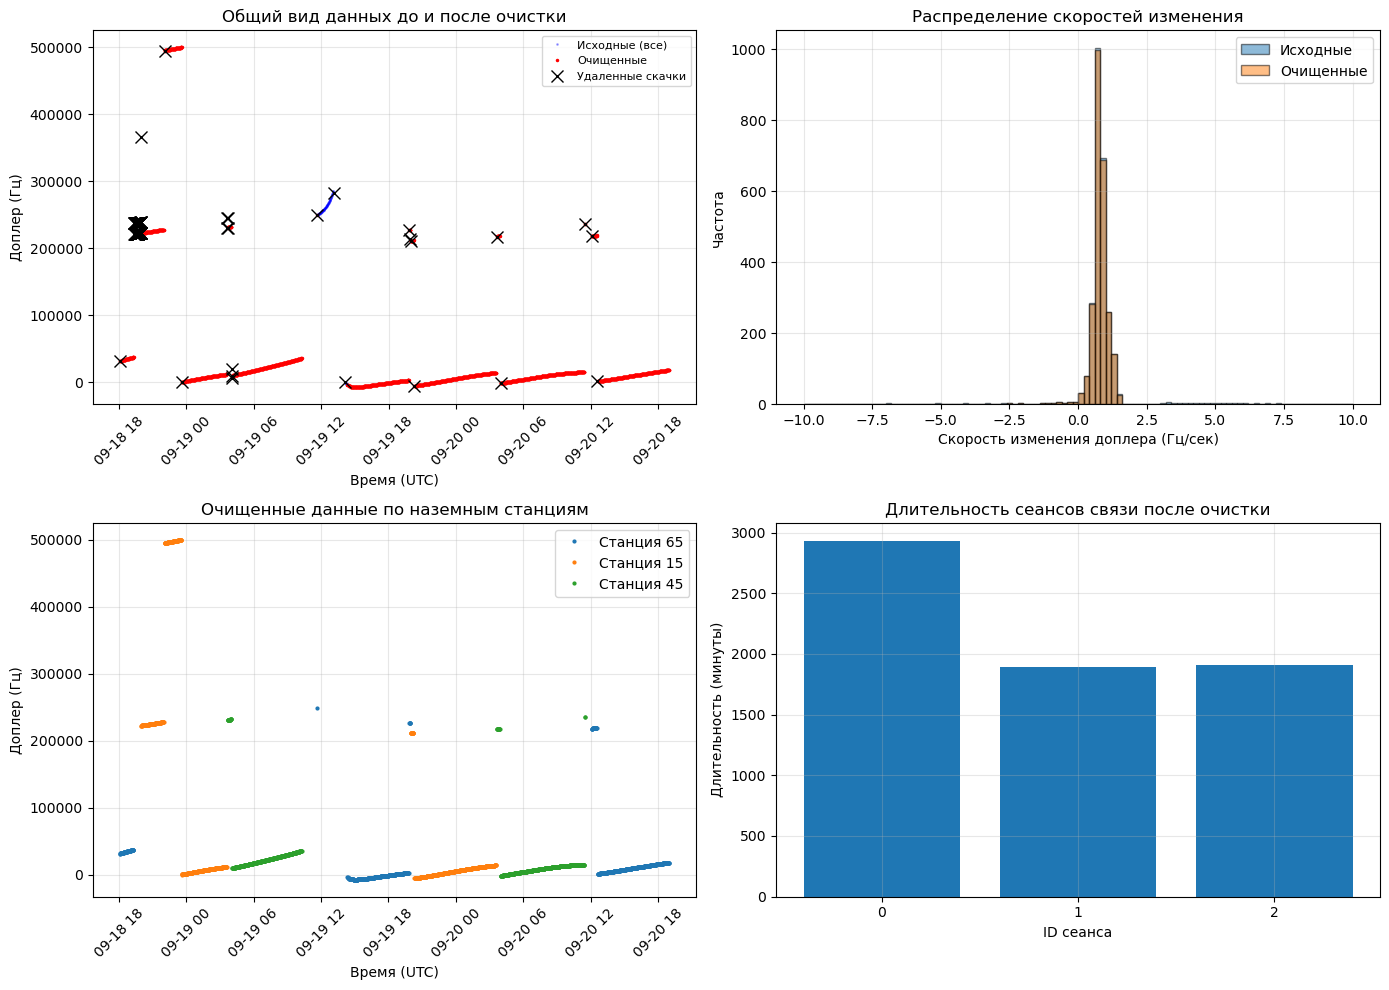


Отчет по очистке сохранен в 'output_data/data_cleaning_report.png'


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# 1. ЗАГРУЖАЕМ ДАННЫЕ ИЗ ВАШЕГО CSV
df = pd.read_csv('output_data/mgs_doppler_results.csv')
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
print(f"Загружено записей: {len(df)}")

# 2. ОСНОВНЫЕ ПРОВЕРКИ
def comprehensive_clean(df, max_jump_hz=1000, max_gap_min=180):
    """
    Функция комплексной очистки данных.
    
    Параметры:
    max_jump_hz: Максимально допустимый скачок доплера между соседними измерениями (Гц).
    max_gap_min: Максимальный разрыв между измерениями для считания их одним сеансом (минуты).
    """
    df_clean = df.sort_values('datetime_utc').copy()
    
    # A. Создаем технические колонки для анализа
    df_clean['time_diff_sec'] = df_clean['datetime_utc'].diff().dt.total_seconds()
    df_clean['doppler_diff'] = df_clean['doppler_hz'].diff()
    df_clean['doppler_rate'] = df_clean['doppler_diff'] / df_clean['time_diff_sec']  # Гц/сек
    
    # B. Фильтр 1: РЕЗКИЕ СКАЧКИ (самый важный!)
    # Это ищет те 7 аномалий. Значение 1000 Гц - строгое, можно ослабить.
    mask_no_jumps = abs(df_clean['doppler_diff']) <= max_jump_hz
    jumps = df_clean[~mask_no_jumps]
    print(f"Найдено резких скачков (> {max_jump_hz} Гц): {len(jumps)}")
    
    # C. Фильтр 2: НЕРЕАЛИСТИЧНАЯ СКОРОСТЬ ИЗМЕНЕНИЯ
    # Физический предел для MGS. Знак может быть + или -.
    max_realistic_rate = 3.0  # Гц/сек (можно увеличить до 5, если нужно)
    mask_good_rate = abs(df_clean['doppler_rate']) <= max_realistic_rate
    bad_rates = df_clean[~mask_good_rate]
    print(f"Записей с нереалистичной скоростью изменения (> {max_realistic_rate} Гц/сек): {len(bad_rates)}")
    
    # D. Фильтр 3: РАЗБИТИЕ НА СЕАНСЫ и анализ целостности
    df_clean['session_id'] = 0
    session_counter = 0
    
    # Группируем по станциям
    for station in df_clean['receiving_station_id'].unique():
        station_mask = df_clean['receiving_station_id'] == station
        station_indices = df_clean[station_mask].index
        
        # Считаем разрыв > max_gap_min минут началом нового сеанса
        time_gaps = df_clean.loc[station_indices, 'time_diff_sec'] > (max_gap_min * 60)
        df_clean.loc[station_indices, 'session_id'] = session_counter + time_gaps.cumsum()
        session_counter = df_clean['session_id'].max() + 1
    
    # E. Применяем все фильтры
    final_mask = mask_no_jumps & mask_good_rate
    df_final = df_clean[final_mask].copy()
    
    # F. Анализ сеансов после очистки
    print(f"\nАнализ сеансов после очистки:")
    for session in sorted(df_final['session_id'].unique()):
        session_data = df_final[df_final['session_id'] == session]
        station = session_data['receiving_station_id'].iloc[0]
        duration = (session_data['datetime_utc'].max() - session_data['datetime_utc'].min()).total_seconds() / 60
        print(f"  Сеанс {int(session)} (Станция {station}): {len(session_data)} зап., длительность {duration:.1f} мин.")
    
    # Статистика очистки
    print(f"\n{'='*50}")
    print(f"ИТОГИ ОЧИСТКИ:")
    print(f"  Исходное количество записей: {len(df)}")
    print(f"  Удалено записей: {len(df) - len(df_final)}")
    print(f"  Осталось записей: {len(df_final)} ({len(df_final)/len(df)*100:.1f}%)")
    print(f"  Получено сеансов: {df_final['session_id'].nunique()}")
    
    # Удаляем технические колонки, если они не нужны
    cols_to_drop = ['time_diff_sec', 'doppler_diff', 'doppler_rate']
    df_final = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns])
    
    return df_final, jumps, bad_rates

# ЗАПУСКАЕМ ОЧИСТКУ
cleaned_df, problem_jumps, problem_rates = comprehensive_clean(df)

# 3. СОХРАНЯЕМ ОЧИЩЕННЫЕ ДАННЫЕ
cleaned_df.to_csv('output_data/mgs_doppler_CLEANED.csv', index=False)
print(f"\nОчищенные данные сохранены в 'output_data/mgs_doppler_CLEANED.csv'")

# 4. ВИЗУАЛИЗИРУЕМ РЕЗУЛЬТАТЫ (опционально, но очень полезно)
def plot_cleaning_results(original_df, cleaned_df, jumps_df):
    """Строит графики для визуальной проверки очистки."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # График 1: Общий вид до и после
    axes[0, 0].plot(original_df['datetime_utc'], original_df['doppler_hz'], 
                   'b.', alpha=0.3, markersize=2, label='Исходные (все)')
    axes[0, 0].plot(cleaned_df['datetime_utc'], cleaned_df['doppler_hz'], 
                   'r.', markersize=3, label='Очищенные')
    if not jumps_df.empty:
        axes[0, 0].plot(jumps_df['datetime_utc'], jumps_df['doppler_hz'], 
                       'kx', markersize=8, label='Удаленные скачки')
    axes[0, 0].set_xlabel('Время (UTC)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].set_ylabel('Доплер (Гц)')
    axes[0, 0].set_title('Общий вид данных до и после очистки')
    axes[0, 0].legend(loc='best', fontsize=8)
    axes[0, 0].grid(True, alpha=0.3)
    
    # График 2: Распределение скоростей изменения
    # Вычисляем скорость для исходных данных
    original_sorted = original_df.sort_values('datetime_utc').copy()
    original_sorted['rate'] = original_sorted['doppler_hz'].diff() / original_sorted['datetime_utc'].diff().dt.total_seconds()
    cleaned_sorted = cleaned_df.sort_values('datetime_utc').copy()
    cleaned_sorted['rate'] = cleaned_sorted['doppler_hz'].diff() / cleaned_sorted['datetime_utc'].diff().dt.total_seconds()
    
    axes[0, 1].hist(original_sorted['rate'].dropna(), bins=100, alpha=0.5, 
                   label='Исходные', edgecolor='black', range=(-10, 10))
    axes[0, 1].hist(cleaned_sorted['rate'].dropna(), bins=100, alpha=0.5, 
                   label='Очищенные', edgecolor='black', range=(-10, 10))
    axes[0, 1].set_xlabel('Скорость изменения доплера (Гц/сек)')
    axes[0, 1].set_ylabel('Частота')
    axes[0, 1].set_title('Распределение скоростей изменения')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # График 3: Данные по станциям (после очистки)
    for station in cleaned_df['receiving_station_id'].unique():
        station_data = cleaned_df[cleaned_df['receiving_station_id'] == station]
        axes[1, 0].plot(station_data['datetime_utc'], station_data['doppler_hz'], 
                       '.', markersize=4, label=f'Станция {station}')
    axes[1, 0].set_xlabel('Время (UTC)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_ylabel('Доплер (Гц)')
    axes[1, 0].set_title('Очищенные данные по наземным станциям')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # График 4: Длительность сеансов
    session_stats = []
    for session in cleaned_df['session_id'].unique():
        sess_data = cleaned_df[cleaned_df['session_id'] == session]
        duration = (sess_data['datetime_utc'].max() - sess_data['datetime_utc'].min()).total_seconds() / 60
        session_stats.append({'Сеанс': int(session), 'Длительность (мин)': duration, 
                            'Записей': len(sess_data)})
    
    if session_stats:
        stats_df = pd.DataFrame(session_stats)
        axes[1, 1].bar(stats_df['Сеанс'].astype(str), stats_df['Длительность (мин)'])
        axes[1, 1].set_xlabel('ID сеанса')
        axes[1, 1].set_ylabel('Длительность (минуты)')
        axes[1, 1].set_title('Длительность сеансов связи после очистки')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output_data/data_cleaning_report.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nОтчет по очистке сохранен в 'output_data/data_cleaning_report.png'")

# Запускаем построение графиков
plot_cleaning_results(df, cleaned_df, problem_jumps)